In [12]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector

class MoralAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        # Initialize moral weights (care, fairness, liberty)
        self.weights = np.random.dirichlet(np.ones(3))
        self.utility_history = []
        self.choice_history = []

    def step(self):
        # Get moral dilemma from model
        dilemma = self.model.dilemmas[self.model.schedule.steps % len(self.model.dilemmas)]
        
        # Calculate utilities for each option
        utilities = [np.dot(self.weights, outcome) for outcome in dilemma]
        
        # Choose best option
        choice = np.argmax(utilities)
        self.utility_history.append(utilities[choice])
        self.choice_history.append(choice)
        
        # Social learning
        if self.model.social_influence:
            self.learn_from_neighbors()

    def learn_from_neighbors(self):
        neighbors = self.model.grid.get_neighbors(self.pos, include_center=False)
        if neighbors:
            # Calculate average neighbor weights
            neighbor_weights = [n.weights for n in neighbors]
            avg_weights = np.mean(neighbor_weights, axis=0)
            
            # Update weights (10% toward neighbors)
            self.weights = 0.9 * self.weights + 0.1 * avg_weights
            self.weights /= np.sum(self.weights)  # Normalize

class MoralModel(Model):
    def __init__(self, num_agents=100, social_influence=True):
        super().__init__()  # CRITICAL FIX: Initialize parent class
        self.num_agents = num_agents
        self.social_influence = social_influence
        self.schedule = RandomActivation(self)
        self.grid = NetworkGrid(nx.watts_strogatz_graph(num_agents, k=4, p=0.3))
        
        # Define moral dilemmas (trolley problem, vaccine distribution, etc.)
        self.dilemmas = [
            [np.array([0.8, -0.2, 0.1]), np.array([-0.1, 0.9, -0.3])],  # Care vs fairness
            [np.array([0.2, 0.6, -0.1]), np.array([0.7, -0.3, 0.4])],    # Fairness vs liberty
            [np.array([-0.3, 0.1, 0.9]), np.array([0.5, 0.5, -0.2])]     # Liberty vs equality
        ]
        
        # Create agents
        for i in range(num_agents):
            agent = MoralAgent(i, self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, i)
            
        # Data collection
        self.datacollector = DataCollector(
            agent_reporters={"Weights": lambda a: a.weights},
            model_reporters={"Moral_Diversity": self.calc_moral_diversity}
        )
    
    def calc_moral_diversity(self):
        weights = [agent.weights for agent in self.schedule.agents]
        return np.mean(np.std(weights, axis=0))
    
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

# Run simulation
model = MoralModel(num_agents=200, social_influence=True)
for _ in range(50):  # Run 50 steps
    model.step()

# Get collected data
agent_data = model.datacollector.get_agent_vars_dataframe()
model_data = model.datacollector.get_model_vars_dataframe()

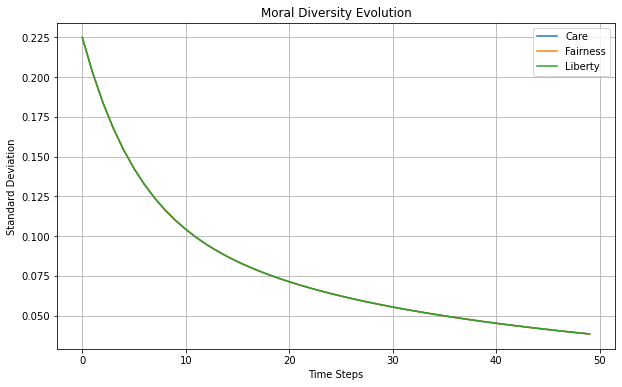

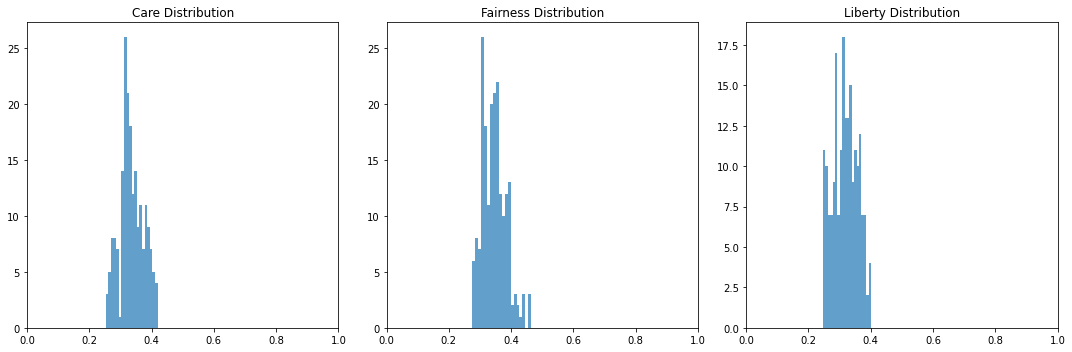

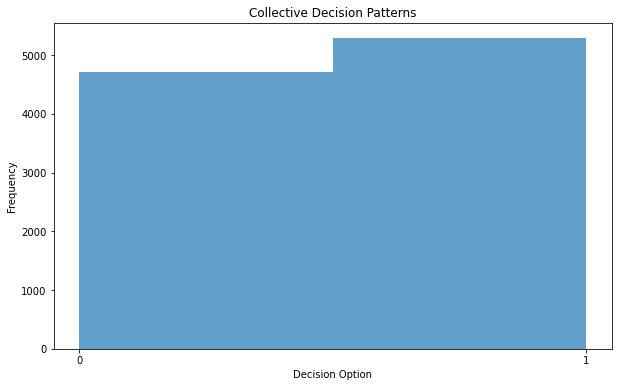

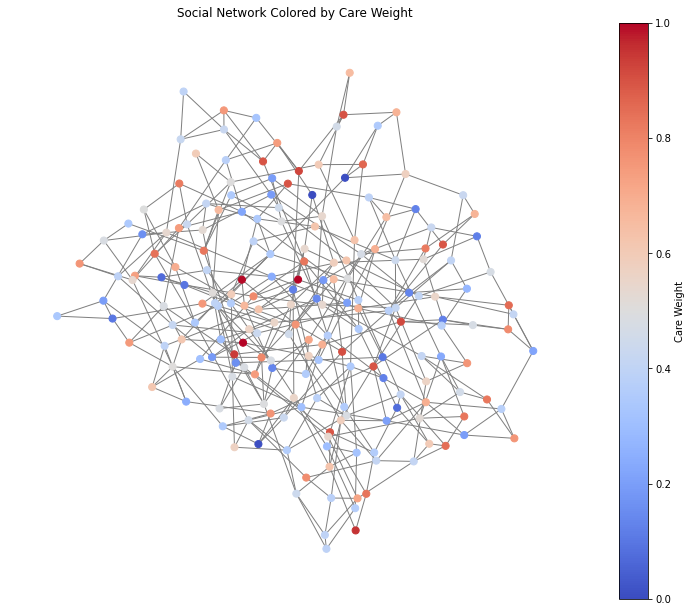

Care-Fairness Correlation: -0.48
Fairness-Liberty Correlation: -0.50
Liberty-Care Correlation: -0.51


In [13]:
# 1. Moral Evolution Over Time
plt.figure(figsize=(10, 6))
for i, weight in enumerate(['Care', 'Fairness', 'Liberty']):
    plt.plot(model_data.index, model_data['Moral_Diversity'], label=weight)
plt.xlabel("Time Steps")
plt.ylabel("Standard Deviation")
plt.title("Moral Diversity Evolution")
plt.legend()
plt.grid(True)
plt.show()

# 2. Final Moral Landscape
final_weights = agent_data.xs(49, level="Step")["Weights"].apply(np.array)
weights_matrix = np.vstack(final_weights.values)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, title in enumerate(['Care', 'Fairness', 'Liberty']):
    ax[i].hist(weights_matrix[:, i], bins=20, alpha=0.7)
    ax[i].set_title(f"{title} Distribution")
    ax[i].set_xlim(0, 1)
plt.tight_layout()

# 3. Decision Patterns Analysis
plt.figure(figsize=(10, 6))
all_choices = np.concatenate([a.choice_history for a in model.schedule.agents])
plt.hist(all_choices, bins=len(model.dilemmas[0]), alpha=0.7)
plt.xlabel("Decision Option")
plt.ylabel("Frequency")
plt.title("Collective Decision Patterns")
plt.xticks(range(len(model.dilemmas[0])))
plt.show()

# 4. Network Visualization with Moral Clusters
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(model.grid.G)
colors = weights_matrix[:, 0]  # Color by care weight

nx.draw(model.grid.G, pos, node_color=colors, 
        cmap=plt.cm.coolwarm, node_size=50, 
        with_labels=False, edge_color="grey")
plt.title("Social Network Colored by Care Weight")
plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.coolwarm), label="Care Weight")
plt.show()

# 5. Correlation Analysis
from scipy.stats import pearsonr

care_fairness = pearsonr(weights_matrix[:, 0], weights_matrix[:, 1])[0]
fairness_liberty = pearsonr(weights_matrix[:, 1], weights_matrix[:, 2])[0]
liberty_care = pearsonr(weights_matrix[:, 2], weights_matrix[:, 0])[0]

print(f"Care-Fairness Correlation: {care_fairness:.2f}")
print(f"Fairness-Liberty Correlation: {fairness_liberty:.2f}")
print(f"Liberty-Care Correlation: {liberty_care:.2f}")

In [14]:
# Run multiple simulations
correlations = []
for _ in range(10):
    model = MoralModel()
    # ... run simulation ...
    weights = np.array([a.weights for a in model.schedule.agents])
    corr = np.corrcoef(weights.T)
    correlations.append(corr)

avg_corr = np.mean(correlations, axis=0)

Text(0.5, 1.0, 'Moral Value Projection')

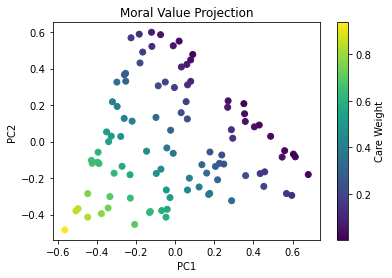

In [15]:
from sklearn.decomposition import PCA

weights_matrix = np.array([agent.weights for agent in model.schedule.agents])
pca = PCA(n_components=2)
coords = pca.fit_transform(weights_matrix)

plt.scatter(coords[:,0], coords[:,1], c=weights_matrix[:,0], cmap='viridis')
plt.colorbar(label='Care Weight')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Moral Value Projection')

In [16]:
# See which values "win" in dilemmas
care_wins = 0
fairness_wins = 0
liberty_wins = 0

for agent in model.schedule.agents:
    for choice in agent.choice_history:
        outcome = model.dilemmas[choice]
        winning_value = np.argmax(outcome)
        if winning_value == 0: care_wins += 1
        elif winning_value == 1: fairness_wins += 1
        else: liberty_wins += 1

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


IndexError: index -1 is out of bounds for axis 1 with size 0

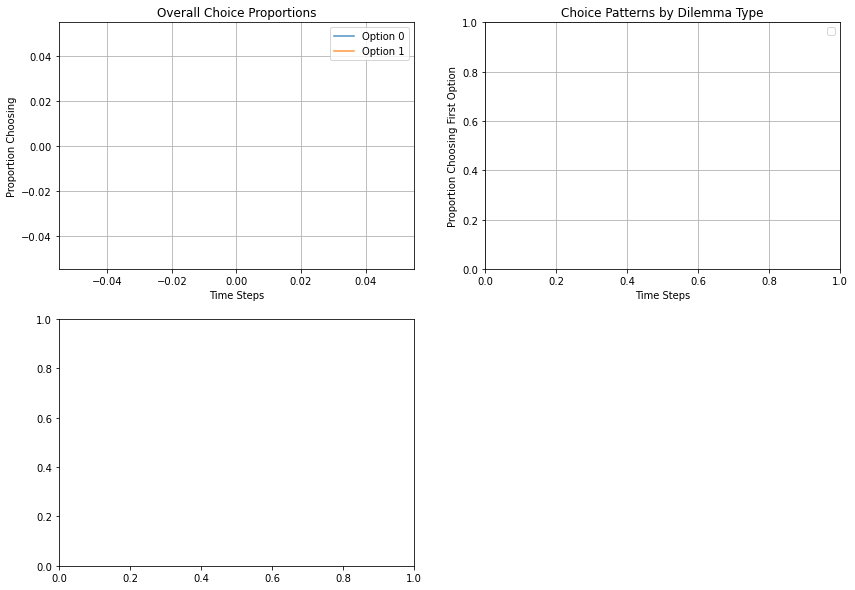

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Assuming your model has been run and agents exist
agents = model.schedule.agents
num_steps = len(agents[0].choice_history)
num_agents = len(agents)

# 1. Create choice matrix (agents x steps)
choices = np.zeros((num_agents, num_steps))
for i, agent in enumerate(agents):
    choices[i] = agent.choice_history

# 2. Dilemma mapping (based on your predefined dilemmas)
dilemma_types = ["Care vs Fairness", "Fairness vs Liberty", "Liberty vs Care"]
dilemma_outcomes = {
    0: {"Care": 0.8, "Fairness": -0.2, "Liberty": 0.1},
    1: {"Care": -0.1, "Fairness": 0.9, "Liberty": -0.3},
    2: {"Care": 0.7, "Fairness": -0.3, "Liberty": 0.4}
}

# 3. Plot choice patterns over time
plt.figure(figsize=(14, 10))

# 3A. Overall choice proportions
plt.subplot(2, 2, 1)
for option in range(2):  # Assuming 2 options per dilemma
    prop_choosing = np.mean(choices == option, axis=0)
    plt.plot(prop_choosing, label=f"Option {option}", alpha=0.8)

plt.xlabel("Time Steps")
plt.ylabel("Proportion Choosing")
plt.title("Overall Choice Proportions")
plt.legend()
plt.grid(True)

# 3B. Choices by dilemma type
plt.subplot(2, 2, 2)
for i, dilemma in enumerate(dilemma_types):
    # Get steps where this dilemma was presented
    dilemma_steps = [s for s in range(num_steps) if s % len(dilemma_types) == i]
    if not dilemma_steps:
        continue
    
    # Calculate proportion choosing option 0 in these steps
    prop_option0 = np.mean(choices[:, dilemma_steps] == 0, axis=0)
    
    # Create x-values for proper time positioning
    plt.plot(dilemma_steps, prop_option0, 'o-', label=dilemma)

plt.xlabel("Time Steps")
plt.ylabel("Proportion Choosing First Option")
plt.title("Choice Patterns by Dilemma Type")
plt.legend()
plt.grid(True)

# 3C. Final choice distribution
plt.subplot(2, 2, 3)
last_choices = choices[:, -1]
choice_counts = [np.sum(last_choices == i) for i in range(2)]

plt.bar(range(2), choice_counts, color=['skyblue', 'salmon'])
plt.xticks(range(2), [f"Option {i}" for i in range(2)])
plt.xlabel("Decision Option")
plt.ylabel("Number of Agents")
plt.title(f"Final Choices at Step {num_steps-1}")

# Add annotations about moral outcomes
for i in range(2):
    plt.text(i, choice_counts[i] + 2, 
             "\n".join([f"{k}:{v:.1f}" for k,v in dilemma_outcomes[i].items()]),
             ha='center', fontsize=9)

# 3D. Choice correlation with moral weights
plt.subplot(2, 2, 4)
weights_matrix = np.array([agent.weights for agent in agents])

# Calculate correlation between weights and choice tendency
choice_tendency = np.mean(choices == 0, axis=1)  # Tendency to choose first option
correlations = [pearsonr(weights_matrix[:, i], choice_tendency)[0] 
               for i in range(3)]

plt.bar(range(3), correlations, color=['green', 'purple', 'orange'])
plt.xticks(range(3), ['Care', 'Fairness', 'Liberty'])
plt.ylabel("Correlation with Choosing First Option")
plt.title("Moral Weights vs Choice Tendency")
plt.axhline(0, color='grey', linestyle='--')

plt.tight_layout()
plt.show()

# 4. Heatmap of choice patterns
plt.figure(figsize=(15, 10))

# 4A. Prepare data
# Sort agents by their moral weights profile
agent_order = np.argsort(weights_matrix[:, 0])  # Sort by care weight

# Create custom colormap
cmap = plt.cm.coolwarm

# 4B. Plot heatmap
ax = sns.heatmap(choices[agent_order], cmap=cmap, cbar_kws={'label': 'Choice Option'})
ax.set_xlabel("Time Steps")
ax.set_ylabel("Agents (Sorted by Care Weight)")
ax.set_title("Agent Choice Patterns Over Time")

# 4C. Add dilemma type indicators
dilemma_colors = ['green', 'purple', 'orange']
for step in range(num_steps):
    dilemma_idx = step % len(dilemma_types)
    ax.add_patch(plt.Rectangle((step, -0.1), 1, 0.1, 
                              color=dilemma_colors[dilemma_idx],
                              transform=ax.get_xaxis_transform()))

# 4D. Create legends
dilemma_legend = [Line2D([0], [0], color=c, lw=4) for c in dilemma_colors]
choice_legend = [Line2D([0], [0], marker='s', color='w', markerfacecolor=cmap(0.), markersize=10),
                 Line2D([0], [0], marker='s', color='w', markerfacecolor=cmap(1.), markersize=10)]

ax.legend(handles=dilemma_legend + choice_legend,
          labels=dilemma_types + ["Option 0", "Option 1"],
          bbox_to_anchor=(1.02, 1), loc='upper left')

plt.tight_layout()
plt.show()

# 5. Moral weight distribution by choice group
option0_weights = weights_matrix[last_choices == 0]
option1_weights = weights_matrix[last_choices == 1]

plt.figure(figsize=(12, 6))
for i, value in enumerate(['Care', 'Fairness', 'Liberty']):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(option0_weights[:, i], label="Option 0", fill=True)
    sns.kdeplot(option1_weights[:, i], label="Option 1", fill=True)
    plt.title(f"{value} Weight Distribution")
    plt.xlabel("Weight Value")
    if i == 0:
        plt.ylabel("Density")
        plt.legend()

plt.suptitle("Moral Weight Distribution by Final Choice")
plt.tight_layout()
plt.show()

/home/ali/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ali/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

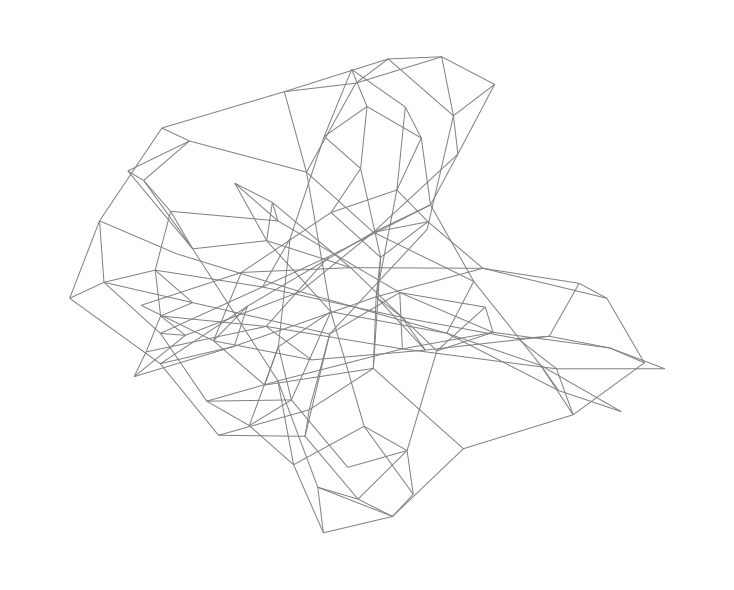

In [18]:
# 6. Network-based choice influence
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(model.grid.G)

# Color by choice consistency
choice_consistency = [np.mean(agent.choice_history == np.median(agent.choice_history)) 
                     for agent in agents]

nx.draw(model.grid.G, pos, node_color=choice_consistency, 
        cmap=plt.cm.viridis, node_size=50, 
        with_labels=False, edge_color="grey")
plt.colorbar(label="Choice Consistency")
plt.title("Network Structure and Choice Consistency")
plt.show()

# 7. Evolutionary choice patterns
choice_changes = np.diff(choices, axis=1)
change_intensity = np.mean(np.abs(choice_changes), axis=0)

plt.figure()
plt.plot(range(1, num_steps), change_intensity)
plt.xlabel("Time Step")
plt.ylabel("Fraction Changing Choice")
plt.title("Decision Stability Over Time")
plt.grid(True)

# 8. Moral alignment vs utility
utilities = np.array([agent.utility_history for agent in agents])
moral_alignment = np.array([w[0] - w[1] for w in weights_matrix])  # Care - Fairness

plt.figure()
plt.scatter(moral_alignment, np.mean(utilities, axis=1), 
            c=last_choices, cmap=plt.cm.coolwarm)
plt.xlabel("Moral Alignment (Care - Fairness)")
plt.ylabel("Average Utility")
plt.title("Moral Position vs Decision Success")
plt.colorbar(label="Final Choice")
plt.show()